# Question 2: **Grouping Customers Together**

In [1]:
import pandas as pd 
import numpy as np
import datetime as dt
from datetime import datetime
import numpy as np
from tqdm import tqdm
import re
from collections import Counter
import warnings

In [2]:
warnings.filterwarnings(action='ignore')

## 2.1.- Getting your data + feature engineering

First we read the dataset from the `csv` file to start working with it.

In [2]:
data=pd.read_csv('bank_transactions.csv')

20 own features:

- Max of transaction 
- Min of transaction 
- Most frequent time of day 
- Age of Costumer from the transaction
- Day of the Week of most Trasactions
- Month of most Trasactions 
- Month when they had more money 
- Num of transactions per month 
- Location where more money is sent from
- Season of most transactions 
- Does the customer change its sex? (1-YES | 0-NO) 
- Period of the day when most transactions are done 
- Section of the population: {Students, Adults, Retired} when last transaction
- Rich or not overall
- If the person's balance is very volatile or not. (1-YES | 0-NO) 
- Log(Account Balance) on average || If Account==0 -> log()=-1
- Increment CustAccountBalance in the year  
- Total amount spent on transactions 
- How many cities have been visitied by that person 
- How many transactions are done at night.


In [3]:
data.dropna(inplace=True)

In [4]:
data.TransactionDate=pd.to_datetime(data.TransactionDate)

In [5]:
data.CustomerDOB=pd.to_datetime(data.CustomerDOB)

In [6]:
data.TransactionTime = data.TransactionTime.apply(lambda x: datetime.strptime(str(x).zfill(6), '%H%M%S'))

<AxesSubplot:>

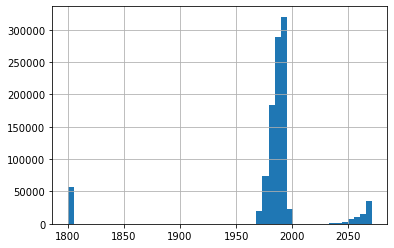

In [7]:
data.CustomerDOB.dt.year.hist(bins=50)

In [8]:
data.loc[data.CustomerDOB.dt.year>2000,'CustomerDOB']=data.loc[data.CustomerDOB.dt.year>2000,'CustomerDOB']-pd.DateOffset(years=100)

We can just drop the data from the people born in 1800s, or consider there is a mistake with the rounding and they are born in 2000, but considering that the dataset is from 2016, I don't think there were 50.000 16-y.o making bank transactions in 2016...

In [9]:
data.loc[data.CustomerDOB.dt.year==1800,'CustomerDOB']=data.loc[data.CustomerDOB.dt.year==1800,'CustomerDOB']+pd.DateOffset(years=200)

<AxesSubplot:>

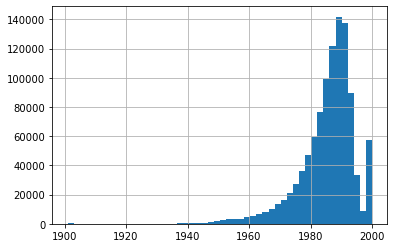

In [10]:
data.CustomerDOB.dt.year.hist(bins=50)

In [11]:
data.CustomerDOB[data.CustomerDOB.dt.year==2000].count()

56561

In [12]:
data['TransactionAmount (INR)'] = data['TransactionAmount (INR)'].astype(int)

Let's try to sort out the locations:

Make a list of the cities with length 1 and then, for the ones that have larger length, looks which one matches and then put it. If non matches, oh well :( . 

Here we create a list with all the locations formed of 1 word, which we are going to consider to be the actual citie names.

In [15]:
cities=[]

for i in data.CustLocation:
    if len(i.split())==1 and bool(re.match('[A-Z]',i)):
        cities.append(i)
cities=np.unique(cities)

Now, for all the `CustLocations` that have length greater than $1$, we will see which of the existing do they match and substitute it to be able to work with the data.

In [127]:
locations=[]
for i in tqdm(range(len(data))):
    if len((data.CustLocation.iloc[i]).split())>1:
        k,j=0,0
        while(k==0):
            if j==len(cities)-1:
                k=1
                locations.append('-')
                pass
            if cities[j] in data.CustLocation.iloc[i]:
                locations.append(cities[j])
                k+=1
            j+=1
    else:
        locations.append(data.CustLocation.iloc[i])

100%|████████████████████████████████| 1041614/1041614 [26:43<00:00, 649.75it/s]


In [151]:
locations=locations[0:len(locations)-2]

In [152]:
data['Location']=locations

In [153]:
data.Locations[data.Locations=='-'].count()

6036

In [154]:
data.to_pickle('data_SatM.pkl')

In [3]:
data=pd.read_pickle('data_SatM.pkl')

In [4]:
data.drop('CustLocation',axis=1,inplace=True)

In [5]:
data.drop('Locations',axis=1,inplace=True)

## Let's make the new features for the DataSet

In [6]:
costumers=data['CustomerID']

In [7]:
costumers=np.unique(costumers)

Now that we have a string with all the costumers, we will search for all the extra features that we have decided to put into the dataset, we will build a new one with the previous and the new features where we also replace the old `CustLocation` by what we have previously named as `Location.` 

In [60]:
def get_features(id):
    
    features={}
    
    t=data[data['CustomerID']==id]
    
    features['CustomerID']=id
    
    #Number of Transactions
    features['N_Transactions']=len(t)
    
    #Number of transaction with balance bigger than 100
    features['N_Transaction_100']=len(t[t.CustAccountBalance>100])
    
    #Average amount of the transactions
    features['AverageAmount']=(t['TransactionAmount (INR)'].sum())/len(t)
    
    #Average Balance
    features['Average Balance']=((t.CustAccountBalance.sum())/len(t)).round(4)
    
    #Average Utilisation
    features['Utilisation']=((t.CustAccountBalance-t['TransactionAmount (INR)']).sum()/len(t)).round(4)
    
    #Most Common Gender (if they are equal, we'll asigne the first one)
    f=t['CustGender'][t['CustGender']=='F'].count()
    m=t['CustGender'][t['CustGender']=='M'].count()
    if m>f:
        features['MostCommonGender']='M'
    elif f>m:
        features['MostCommonGender']='F'
    else:
        features['MostCommonGender']=t.iloc[0]['CustGender']
    
    #Most Frequent Location
    features['MostFreqLocation']=Counter(t['Location']).most_common(1)[0][0]
    
    #Now we proceed with the 20 one selected by us
    
    #Max of Transactions
    features['MaxTransaction']=max(t['TransactionAmount (INR)'])
    
    #Min of Transactions
    features['MinTransaction']=min(t['TransactionAmount (INR)'])
    
    #Most frequent time of Transaction (hour)
    features['MostFreqTime']=Counter(t.TransactionTime.dt.hour).most_common(1)[0][0]
    
    #Age of Customer in first transaction
    features['AverageAge']=((pd.to_datetime('today')-data.CustomerDOB)/np.timedelta64(1,'Y')).iloc[len(t)-1].round()
    
    #Day of the Week with most transactions
    days_week={0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
    aux=Counter(t.TransactionDate.dt.day_of_week).most_common(1)[0][0]
    features['Day_of_Week']=days_week[aux]
    
    #Month with most transactions
    months={1:'Jan',2:'Feb',3:'March',4:'April',5:'May',6:'June',7:'July',8:'Aug',9:'Sept',10:'Oct',11:'Nov',12:'Dec'}
    aux=Counter(t.TransactionDate.dt.month).most_common(1)[0][0]
    features['Month']=months[aux]
    
    #Month with higher Balance
    features['Month_Higher_Balance']=t[t['CustAccountBalance']==max(t['CustAccountBalance'])]['TransactionDate'].dt.month.apply(lambda x:months[x]).iloc[0]

    #Location where more money is sent from
    features['MoreMoneyLoc']=t[t['TransactionAmount (INR)']==max(t['TransactionAmount (INR)'])].Location.iloc[0]
    
    #Season of First Transaction
    season={1:'W',2:'W',3:'Sp',4:'Sp',5:'Sp',6:'Su',7:'Su',8:'Su',9:'Au',10:'Au',11:'Au',12:'W'}
    features['Season']=season[t['TransactionDate'].dt.month.iloc[0]]
    
    #Does the Customer Change Sex along transactions?
    if m!=0 and f!=0:
        features['SexChange']=1
    else:
        features['SexChange']=0
    
    #Period of the Day of more transactions
    def period(time):
        if time in [21,22,23,24,0,1,2,3,4,5]:
            return 'Night'
        elif time in [6,7,8,9,10,11,12]:
            return 'Morning'
        elif time in [13,14,15,16]:
            return 'Afternoon'
        elif time in [17,18,19,20]:
            return 'Evening'
        
    aux=Counter(t.TransactionDate.dt.hour).most_common(1)[0][0]
    features['Period']=period(aux)
    
    # Section of Population
    def section(age):
        if age<=25:
            return 'Student'
        elif 25<age and age<65:
            return 'Adult'
        elif age>=65:
            return 'Retired'
        
    features['Section']=section(((pd.to_datetime('today')-data.CustomerDOB)/np.timedelta64(1,'Y')).iloc[len(t)-1])
    
    # Rich or Poor in the moment of transaction (we will consider rich if in the moment has a balance over 100.000)
    def richpoor(x):
        if x<100000:
            return 'Poor'
        else:
            return 'Rich'
    features['RichPoor']=richpoor(t.CustAccountBalance.sum()/len(t))
    
    #Is the Balance Volatile or Variable? If the standard deviation is higher than then average, we'll say it is(1)
    features['Volatile_Balance']=int(t.CustAccountBalance.std()>t.CustAccountBalance.mean())
    
    #Log Account Balance:
    aux=np.log10(t.CustAccountBalance.sum()).round(4)
    if aux==-np.inf:
        aux=-1
    features['LogCustAccountBalance']=aux
    
    #Increment CustAccountBalance in the year: final -initial
    features['Increment']=(t['CustAccountBalance'].iloc[len(t)-1]-t['CustAccountBalance'].iloc[0]).round(4)
    
    #Total Amount Spent on Transactions
    features['TotalTransactions']=t['TransactionAmount (INR)'].sum()
    
    #Cities Visited
    features['Num_Cities']=len(np.unique(t['Location']))
    
    #Transactions Done at Night
    night=t['TransactionTime'].dt.hour.apply(period)
    features['NightTransactions']=len(night[night=='Night'])
    
    return features

In [62]:
#We put the first `CustomerID` and we proceed with the rest of the features
info=get_features(costumers[0])
new_data=pd.DataFrame(info,index=[0])

for i in tqdm(range(len(costumers[1:]))):
    info=get_features(costumers[i])
    aux=pd.DataFrame(info,index=[i+1])
    new_data=new_data.append(aux)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 879357/879357 [29:09:28<00:00,  8.38it/s]


In [63]:
final.to_pickle('finaldata.pkl')

In [69]:
aux=new_data.groupby('CustomerID').value_counts().to_frame()

In [74]:
data=new_data[['CustomerID','N_Transactions','N_Transaction_100','AverageAmount','Average Balance','Utilisation','MostCommonGender','MostFreqLocation','MaxTransaction','MinTransaction','MostFreqTime','AverageAge','Day_of_Week','Month','Month_Higher_Balance','MoreMoneyLoc','Season','SexChange','Period','Section','RichPoor','Volatile_Balance','LogCustAccountBalance','Increment','TotalTransactions','Num_Cities','NightTransactions']]

In [75]:
data.drop_duplicates(inplace=True)

In [79]:
data.set_index('CustomerID',inplace=True)

In [81]:
data.to_csv('Bank_Features.csv',sep='\t')
data.to_pickle('NewData.pkl')